# Monte Carlo Simulation

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd

def simulate_tests(p, k, num_simulations=10000):
    total_tests = tf.constant(0, dtype=tf.float32)

    for _ in range(num_simulations):
        infected_individuals = tf.random.categorical(tf.math.log([[1 - p, p]]), N)
        batch_tests = tf.reduce_sum(infected_individuals[:k]) > 0

        if batch_tests:  # If batch tests positive, test all individuals in the batch
            individual_tests = tf.cast(tf.reduce_sum(infected_individuals[:k]), dtype=tf.float32)
        else:  # If batch tests negative, no need to test individuals
            individual_tests = tf.constant(0, dtype=tf.float32)

        total_tests += tf.constant(1.0, dtype=tf.float32) + individual_tests  # Count the tests conducted

    expected_tests = total_tests / tf.constant(num_simulations, dtype=tf.float32)
    return expected_tests.numpy()

# Parameters
N = int(1e6)  # Total number of samples
p_values = [10**(-i) for i in range(1, 6)]  # Values of p to test (changed to 10**(-5))

# Store results
results = {}

# Perform simulations for different p values and find optimal batch sizes
for p in p_values:
    print(p)
    min_expected_tests = float('inf')
    best_k = 1
    lower_bound = 1
    upper_bound = int(np.sqrt(N))  # Starting upper bound

    while lower_bound <= upper_bound:
        mid = (lower_bound + upper_bound) // 2  # Calculate midpoint
        expected_tests = simulate_tests(p, mid)

        if expected_tests < min_expected_tests:
            min_expected_tests = expected_tests
            best_k = mid

        if expected_tests == 1:  # If expected_tests == 1, the optimal batch size is found
            break
        elif expected_tests > 1:
            upper_bound = mid - 1
        else:
            lower_bound = mid + 1

    results[p] = (best_k, min_expected_tests)

# Create a DataFrame to display the results in a table
table_data = {'p': [], 'Optimal Batch Size': [], 'Expected Tests': []}
for p, (best_k, min_tests) in results.items():
    table_data['p'].append(p)
    table_data['Optimal Batch Size'].append(best_k)
    table_data['Expected Tests'].append(min_tests)

results_table = pd.DataFrame(table_data)

# Display the table
print("Table of Optimal Batch Sizes and Expected Tests:")
print(results_table)



0.1
0.01
0.001
0.0001
1e-05
Table of Optimal Batch Sizes and Expected Tests:
         p  Optimal Batch Size  Expected Tests
0  0.10000                  31    99996.960938
1  0.01000                  62    10000.081055
2  0.00100                  15     1000.148621
3  0.00010                 500      100.789497
4  0.00001                   1       10.886800


In [ ]:
# Total number of samples
N = int(1e6)  # For example, 1 million samples

# Reduction in workload for each p value
reduction_workload = {}

# Calculate reduction in workload for each p value using the optimal batch sizes and expected tests from the table
for p, (optimal_batch_size, expected_tests) in results.items():
    # Calculate number of tests using batch testing
    tests_using_batch_testing = N // optimal_batch_size + (N % optimal_batch_size > 0)

    # Reduction in workload = Total number of tests with individual testing - Total number of tests with batch testing
    reduction_workload[p] = N - tests_using_batch_testing

# Summarize the total reduction in workload compared to individual testing
total_reduction = sum(reduction_workload.values())

# Display the reduction in workload for each p value and the total reduction
print("Reduction in Workload Compared to Individual Testing:")
for p, reduction in reduction_workload.items():
    print(f"For p = {p}: Reduction in workload = {reduction} tests")

print(f"\nTotal reduction in workload compared to individual testing = {total_reduction} tests")


Reduction in Workload Compared to Individual Testing:
For p = 0.1: Reduction in workload = 967741 tests
For p = 0.01: Reduction in workload = 983870 tests
For p = 0.001: Reduction in workload = 933333 tests
For p = 0.0001: Reduction in workload = 998000 tests
For p = 1e-05: Reduction in workload = 0 tests

Total reduction in workload compared to individual testing = 3882944 tests


# Thompson

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta

# Function to perform Thompson Sampling update for single arm bandit
def thompson_sampling(iterations):
    alpha = 1
    beta = 1
    means = []
    variances = []

    for i in range(1, iterations+1):
        # Sample from the Beta distribution
        sampled_prob = np.random.beta(alpha, beta)

        # Get reward (simulate bandit) - Assuming a reward of 1 with probability sampled_prob
        reward = np.random.choice([0, 1], p=[1 - sampled_prob, sampled_prob])

        # Update alpha and beta
        alpha += reward
        beta += 1 - reward

        # Calculate mean and variance
        mean = alpha / (alpha + beta)
        variance = (alpha * beta) / ((alpha + beta) ** 2 * (alpha + beta + 1))

        means.append(mean)
        variances.append(variance)

    return means, variances

print("Ladila")

num_iterations = 500

mean_values, variance_values = thompson_sampling(num_iterations)

Ladila


In [ ]:
# Plot evolution of mean over time
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_iterations+1), mean_values, label='Mean')
plt.xlabel('Iterations')
plt.ylabel('Mean')
plt.title('Evolution of Mean in Thompson Sampling')
plt.legend()
plt.show()

# Plot evolution of variance over time
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_iterations+1), variance_values, label='Variance')
plt.xlabel('Iterations')
plt.ylabel('Variance')
plt.title('Evolution of Variance in Thompson Sampling')
plt.legend()
plt.show()

## Thompson for k-armed

In [ ]:
import numpy as np


def thompson_sampling_arms(iterations):
    alpha = [1, 1, 1]
    beta = [1, 1, 1]
    cumulative_rewards = [0, 0, 0]  # Cumulative rewards for each arm

    for i in range(iterations):
        # Change range
        sampled_values = [np.random.beta(alpha[k], beta[k]) for k in range(3)]

        # Determine max sampled value
        k_max = np.argmax(sampled_values)

        # Simulate pulling the k_max arm and obtain reward
        reward = np.random.choice([0, 1], p=[1 - sampled_values[k_max], sampled_values[k_max]])

        # Update parameters based on observed reward for the k_max arm
        alpha[k_max] += reward
        beta[k_max] += 1 - reward

        # Update cumulative rewards for the chosen arm
        cumulative_rewards[k_max] += reward

    return cumulative_rewards

# Number of iterations
num_iterations = 1000

cumulative_rewards = thompson_sampling_arms(num_iterations)

# Display cumulative rewards for each arm
for k in range(3):
    print(f"Total reward for arm {k+1}: {cumulative_rewards[k]}")


In [ ]:
def thompson_sampling_K3(iterations):
    alpha = [1, 1, 1]
    beta = [1, 1, 1]
    cumulative_rewards = [0, 0, 0]
    total_reward = 0
    optimal_rewards = [0.5, 0.6, 0.7]

    regret = []

    for i in range(1, iterations + 1):
        sampled_values = [np.random.beta(alpha[k], beta[k]) for k in range(3)]
        k_max = np.argmax(sampled_values)

        reward = np.random.choice([0, 1], p=[1 - optimal_rewards[k_max], optimal_rewards[k_max]])

        alpha[k_max] += reward
        beta[k_max] += 1 - reward

        cumulative_rewards[k_max] += reward
        total_reward += reward

        instant_regret = max(optimal_rewards) - optimal_rewards[k_max]
        regret.append(instant_regret)

    return regret

In [ ]:
# Change values of c
def ucb_K3(iterations, c):
    alpha = [0] * 3
    beta = [0] * 3
    counts = [0] * 3  # TODO check this
    cumulative_rewards = [0] * 3
    total_reward = 0
    optimal_rewards = [0.5, 0.6, 0.7]

    regret = []

    for i in range(1, iterations + 1):
        if 0 in counts:
            k = counts.index(0)  # TODO - Change probably?????
        else:
            ucb_values = [alpha[k] / (alpha[k] + beta[k]) + c * np.sqrt(np.log(i) / counts[k]) for k in range(3)]
            k = np.argmax(ucb_values)

        reward = np.random.choice([0, 1], p=[1 - optimal_rewards[k], optimal_rewards[k]])

        alpha[k] += reward
        beta[k] += 1 - reward
        counts[k] += 1

        cumulative_rewards[k] += reward
        total_reward += reward

        instant_regret = max(optimal_rewards) - optimal_rewards[k]
        regret.append(instant_regret)

    return regret

In [ ]:
# Number of iterations
num_iterations = 1000
num_runs = 100

# Perform Thompson Sampling for K=3 arms
ts_total_regret = np.zeros(num_iterations)
for run in range(num_runs):
    ts_regret = thompson_sampling_K3(num_iterations)
    ts_total_regret += np.cumsum(ts_regret)

# Calculate average regret for Thompson Sampling
ts_average_regret = ts_total_regret / num_runs

# Perform UCB for K=3 arms with different values of c
c_values = [0.5, 1, 2]
ucb_total_regret = {c: np.zeros(num_iterations) for c in c_values}

for c in c_values:
    for run in range(num_runs):
        ucb_regret = ucb_K3(num_iterations, c)
        ucb_total_regret[c] += np.cumsum(ucb_regret)

# Calculate average regret for UCB with different values of c
ucb_average_regret = {c: ucb_total_regret[c] / num_runs for c in c_values}

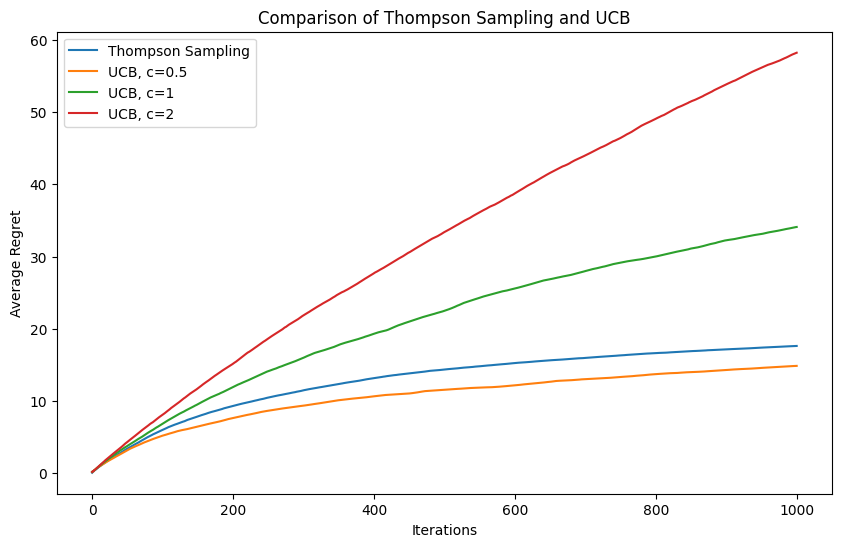

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(ts_average_regret, label='Thompson Sampling')
for c in c_values:
    plt.plot(ucb_average_regret[c], label=f'UCB, c={c}')
plt.xlabel('Iterations')
plt.ylabel('Average Regret')
plt.title('Comparison of Thompson Sampling and UCB')
plt.legend()
plt.show()

# RL: Cliff Walking

In [2]:
import random
import numpy as np

# Constants
ROWS = 3
COLS = 21
START = (2, 0)
GOAL = (2, 20)
ACTIONS = ['UP', 'DOWN', 'LEFT', 'RIGHT']
EPSILON = 0.1
ALPHA = 0.5
GAMMA = 1.0
EPISODES = 500
REPLAY_BUFFER_SIZE = 100

# Initialize Q-values
q_values_sarsa = np.zeros((ROWS, COLS, len(ACTIONS)))
q_values_qlearning = np.zeros((ROWS, COLS, len(ACTIONS)))

# Helper function to choose action using epsilon-greedy policy
def epsilon_greedy_policy(q_values, state, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        return np.random.choice(len(ACTIONS))
    else:
        return np.argmax(q_values[state])

# SARSA algorithm
def sarsa():
    rewards_per_episode = []
    for episode in range(EPISODES):
        state = START
        action = epsilon_greedy_policy(q_values_sarsa, state, EPSILON)
        total_reward = 0

        while state != GOAL:
            next_state = state
            if ACTIONS[action] == 'UP':
                next_state = (max(state[0] - 1, 0), state[1])
            elif ACTIONS[action] == 'DOWN':
                next_state = (min(state[0] + 1, ROWS - 1), state[1])
            elif ACTIONS[action] == 'LEFT':
                next_state = (state[0], max(state[1] - 1, 0))
            elif ACTIONS[action] == 'RIGHT':
                next_state = (state[0], min(state[1] + 1, COLS - 1))

            reward = -1
            if next_state[0] == 2 and 1 <= next_state[1] <= 18:  # Cliff region
                reward = -100

            next_action = epsilon_greedy_policy(q_values_sarsa, next_state, EPSILON)
            q_values_sarsa[state][action] += ALPHA * (reward + GAMMA * q_values_sarsa[next_state][next_action] - q_values_sarsa[state][action])
            state = next_state
            action = next_action
            total_reward += reward

        rewards_per_episode.append(total_reward)

    return rewards_per_episode

def q_learning_without_replay():
    rewards_per_episode = []

    for episode in range(EPISODES):
        state = START
        total_reward = 0

        while state != GOAL:
            action = epsilon_greedy_policy(q_values_qlearning, state, EPSILON)
            next_state = state
            if ACTIONS[action] == 'UP':
                next_state = (max(state[0] - 1, 0), state[1])
            elif ACTIONS[action] == 'DOWN':
                next_state = (min(state[0] + 1, ROWS - 1), state[1])
            elif ACTIONS[action] == 'LEFT':
                next_state = (state[0], max(state[1] - 1, 0))
            elif ACTIONS[action] == 'RIGHT':
                next_state = (state[0], min(state[1] + 1, COLS - 1))

            reward = -1
            if next_state[0] == 2 and 1 <= next_state[1] <= 18:  # Cliff region
                reward = -100

            q_values_qlearning[state][action] += ALPHA * (
                    reward + GAMMA * np.max(q_values_qlearning[next_state]) - q_values_qlearning[state][action])

            state = next_state
            total_reward += reward

        rewards_per_episode.append(total_reward)

    return rewards_per_episode

# Q-learning algorithm with replay buffer
def q_learning():
    rewards_per_episode = []
    replay_buffer = []

    for episode in range(EPISODES):
        state = START
        total_reward = 0

        while state != GOAL:
            action = epsilon_greedy_policy(q_values_qlearning, state, EPSILON)
            next_state = state
            if ACTIONS[action] == 'UP':
                next_state = (max(state[0] - 1, 0), state[1])
            elif ACTIONS[action] == 'DOWN':
                next_state = (min(state[0] + 1, ROWS - 1), state[1])
            elif ACTIONS[action] == 'LEFT':
                next_state = (state[0], max(state[1] - 1, 0))
            elif ACTIONS[action] == 'RIGHT':
                next_state = (state[0], min(state[1] + 1, COLS - 1))

            reward = -1
            if next_state[0] == 2 and 1 <= next_state[1] <= 18:  # Cliff region
                reward = -100

            replay_buffer.append((state, action, reward, next_state))
            if len(replay_buffer) > REPLAY_BUFFER_SIZE:
                replay_buffer.pop(0)

            # Q-learning update
            sample = random.choice(replay_buffer)
            q_values_qlearning[sample[0]][sample[1]] += ALPHA * (
                    sample[2] + GAMMA * np.max(q_values_qlearning[sample[3]]) - q_values_qlearning[sample[0]][sample[1]])

            state = next_state
            total_reward += reward

        rewards_per_episode.append(total_reward)

    return rewards_per_episode



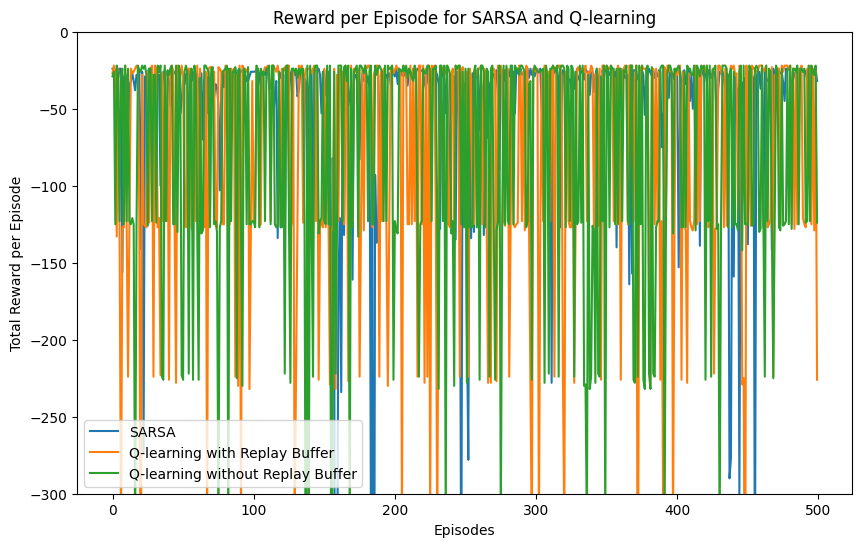

In [37]:
# Run SARSA and Q-learning without replay buffer
rewards_sarsa = sarsa()
rewards_qlearning = q_learning()
rewards_qlearning_without_replay = q_learning_without_replay()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(np.arange(EPISODES), rewards_sarsa, label='SARSA')
plt.plot(np.arange(EPISODES), rewards_qlearning, label='Q-learning with Replay Buffer')
plt.plot(np.arange(EPISODES), rewards_qlearning_without_replay, label='Q-learning without Replay Buffer')
plt.xlabel('Episodes')
plt.ylabel('Total Reward per Episode')
plt.title('Reward per Episode for SARSA and Q-learning')
plt.legend()
plt.ylim(-300, 0)
plt.show()

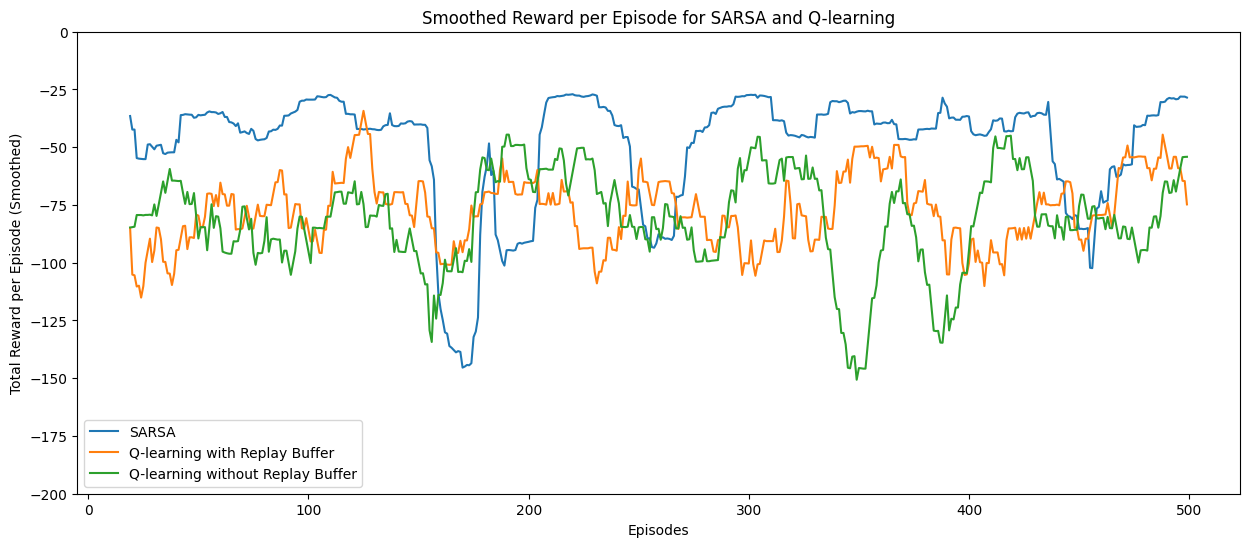

In [38]:
# Function for calculating moving average
def moving_average(data, window_size):
    cumsum = np.cumsum(data)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

# Smoothing window size
window_size = 20

# Calculate moving average for SARSA rewards
smoothed_rewards_sarsa = moving_average(rewards_sarsa, window_size)

# Calculate moving average for Q-learning rewards
smoothed_rewards_qlearning = moving_average(rewards_qlearning, window_size)

# Calculate moving average for SARSA rewards without replay buffer
smoothed_rewards_qlearning_without_replay = moving_average(rewards_qlearning_without_replay, window_size)

plt.figure(figsize=(15, 6))
plt.plot(np.arange(window_size - 1, EPISODES), smoothed_rewards_sarsa, label='SARSA')
plt.plot(np.arange(window_size - 1, EPISODES), smoothed_rewards_qlearning, label='Q-learning with Replay Buffer')
plt.plot(np.arange(window_size - 1, EPISODES), smoothed_rewards_qlearning_without_replay, label='Q-learning without Replay Buffer')
plt.xlabel('Episodes')
plt.ylabel('Total Reward per Episode (Smoothed)')
plt.title('Smoothed Reward per Episode for SARSA and Q-learning')
plt.legend()
plt.ylim(-200, 0)
plt.show()

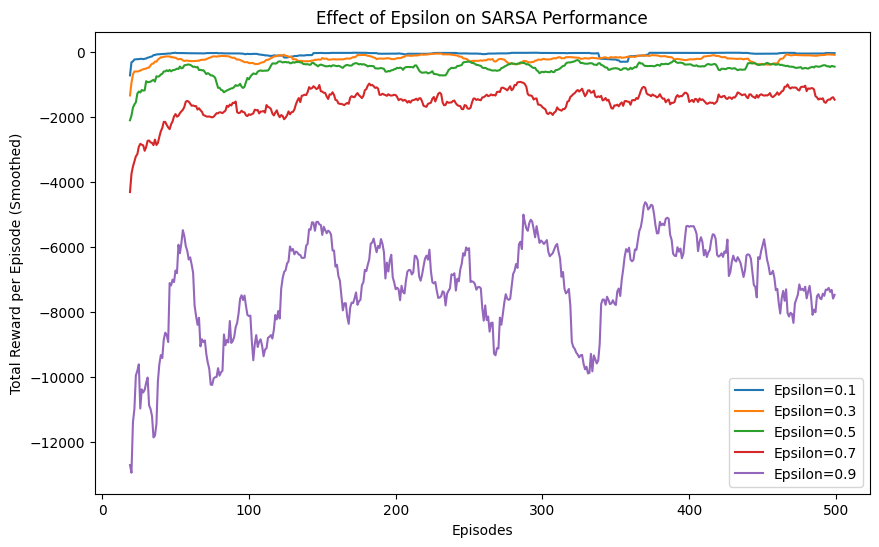

In [39]:
def run_sarsa_for_epsilon(epsilon):
    q_values_sarsa = np.zeros((ROWS, COLS, len(ACTIONS)))
    rewards_per_episode = []

    for episode in range(EPISODES):
        state = START
        action = epsilon_greedy_policy(q_values_sarsa, state, epsilon)
        total_reward = 0

        while state != GOAL:
            next_state = state
            if ACTIONS[action] == 'UP':
                next_state = (max(state[0] - 1, 0), state[1])
            elif ACTIONS[action] == 'DOWN':
                next_state = (min(state[0] + 1, ROWS - 1), state[1])
            elif ACTIONS[action] == 'LEFT':
                next_state = (state[0], max(state[1] - 1, 0))
            elif ACTIONS[action] == 'RIGHT':
                next_state = (state[0], min(state[1] + 1, COLS - 1))

            reward = -1
            if next_state[0] == 2 and 1 <= next_state[1] <= 18:  # Cliff region
                reward = -100

            next_action = epsilon_greedy_policy(q_values_sarsa, next_state, epsilon)
            q_values_sarsa[state][action] += ALPHA * (
                    reward + GAMMA * q_values_sarsa[next_state][next_action] - q_values_sarsa[state][action])

            state = next_state
            action = next_action
            total_reward += reward

        rewards_per_episode.append(total_reward)

    return moving_average(rewards_per_episode, window_size)

epsilons = [0.1, 0.3, 0.5, 0.7, 0.9]
smoothed_rewards = []

for epsilon in epsilons:
    smoothed_rewards.append(run_sarsa_for_epsilon(epsilon))

# Plotting
plt.figure(figsize=(10, 6))
for i, epsilon in enumerate(epsilons):
    plt.plot(np.arange(window_size - 1, EPISODES), smoothed_rewards[i], label=f'Epsilon={epsilon}')

plt.xlabel('Episodes')
plt.ylabel('Total Reward per Episode (Smoothed)')
plt.title('Effect of Epsilon on SARSA Performance')
plt.legend()
plt.show()

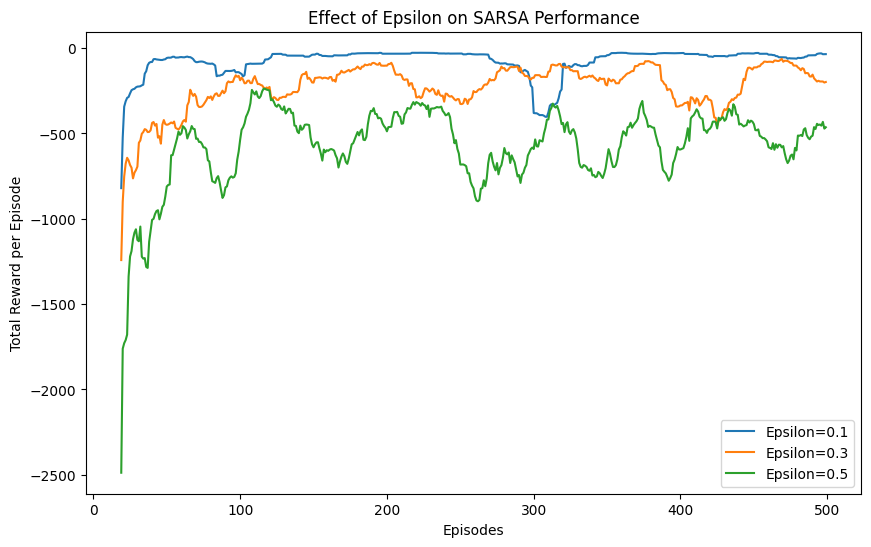

In [49]:
epsilons = [0.1, 0.3, 0.5]
smoothed_rewards = []

for epsilon in epsilons:
    smoothed_rewards.append(run_sarsa_for_epsilon(epsilon))

# Plotting
plt.figure(figsize=(10, 6))
for i, epsilon in enumerate(epsilons):
    plt.plot(np.arange(window_size - 1, EPISODES), smoothed_rewards[i], label=f'Epsilon={epsilon}')

plt.xlabel('Episodes')
plt.ylabel('Total Reward per Episode')
plt.title('Effect of Epsilon on SARSA Performance')
plt.legend()
plt.show()

In [44]:
def run_sarsa_with_snake_pits():
    q_values_sarsa = np.zeros((ROWS, COLS, len(ACTIONS)))
    rewards_per_episode = []

    for episode in range(EPISODES):
        state = START
        action = epsilon_greedy_policy(q_values_sarsa, state, EPSILON)
        total_reward = 0

        while state != GOAL:
            next_state = state
            if ACTIONS[action] == 'UP':
                next_state = (max(state[0] - 1, 0), state[1])
            elif ACTIONS[action] == 'DOWN':
                next_state = (min(state[0] + 1, ROWS - 1), state[1])
            elif ACTIONS[action] == 'LEFT':
                next_state = (state[0], max(state[1] - 1, 0))
            elif ACTIONS[action] == 'RIGHT':
                next_state = (state[0], min(state[1] + 1, COLS - 1))

            reward = -1
            # Handling the cliff and snake pits
            if next_state[0] == 2 and 1 <= next_state[1] <= 18:  # Cliff region
                reward = -100
            elif next_state[0] == 2 and next_state[1] in (10, 11):  # Snake pits
                reward = -100

            next_action = epsilon_greedy_policy(q_values_sarsa, next_state, EPSILON)
            q_values_sarsa[state][action] += ALPHA * (
                    reward + GAMMA * q_values_sarsa[next_state][next_action] - q_values_sarsa[state][action])

            state = next_state
            action = next_action
            total_reward += reward

        rewards_per_episode.append(total_reward)

    return moving_average(rewards_per_episode, window_size)

# Function to run Q-learning with snake pits
def run_q_learning_with_snake_pits():
    q_values_qlearning = np.zeros((ROWS, COLS, len(ACTIONS)))
    rewards_per_episode = []

    for episode in range(EPISODES):
        state = START
        total_reward = 0

        while state != GOAL:
            action = epsilon_greedy_policy(q_values_qlearning, state, EPSILON)
            next_state = state
            if ACTIONS[action] == 'UP':
                next_state = (max(state[0] - 1, 0), state[1])
            elif ACTIONS[action] == 'DOWN':
                next_state = (min(state[0] + 1, ROWS - 1), state[1])
            elif ACTIONS[action] == 'LEFT':
                next_state = (state[0], max(state[1] - 1, 0))
            elif ACTIONS[action] == 'RIGHT':
                next_state = (state[0], min(state[1] + 1, COLS - 1))

            reward = -1
            # Handling the cliff and snake pits
            if next_state[0] == 2 and 1 <= next_state[1] <= 18:  # Cliff region
                reward = -100
            elif next_state[0] == 2 and next_state[1] in (10, 11):  # Snake pits
                reward = -100

            q_values_qlearning[state][action] += ALPHA * (
                    reward + GAMMA * np.max(q_values_qlearning[next_state]) - q_values_qlearning[state][action])

            state = next_state
            total_reward += reward

        rewards_per_episode.append(total_reward)

    return moving_average(rewards_per_episode, window_size)

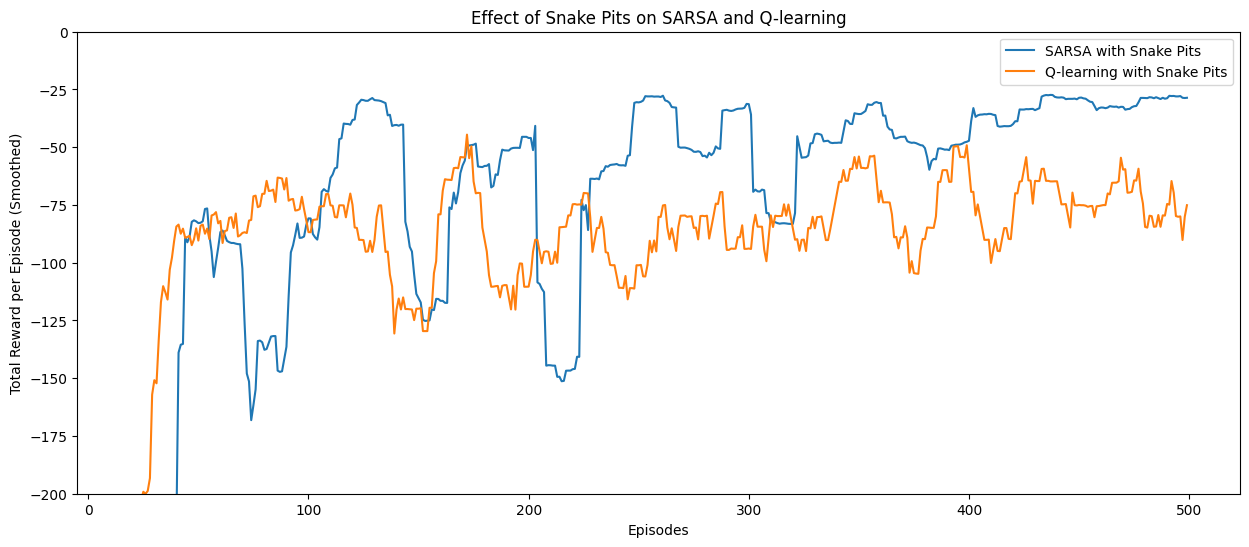

In [47]:
# Run SARSA and Q-learning with snake pits
smoothed_rewards_sarsa_with_snakes = run_sarsa_with_snake_pits()
smoothed_rewards_qlearning_with_snakes = run_q_learning_with_snake_pits()

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(np.arange(window_size - 1, EPISODES), smoothed_rewards_sarsa_with_snakes, label='SARSA with Snake Pits')
plt.plot(np.arange(window_size - 1, EPISODES), smoothed_rewards_qlearning_with_snakes, label='Q-learning with Snake Pits')
plt.xlabel('Episodes')
plt.ylabel('Total Reward per Episode (Smoothed)')
plt.title('Effect of Snake Pits on SARSA and Q-learning')
plt.legend()
plt.ylim(-200,0)
plt.show()